# Predicting the presence of a heart disease
***
## Data description
The dataset contains medical information about patients from Cleveland, who either suffered or not from a heart disease. The problem analyzed in this project is to try and detect whether a patient has a heart disease or not based on his current condition which is described by a set of variables explained later. The dataset was downloaded from **[here](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)** and is named *processed.cleveland.data*.


Firstly we need to import the data and check the dimensions to see what is the size of the dataset.

In [366]:
import pandas as pd
import os

data = pd.read_csv(os.getcwd() + '\\processed.cleveland.data', header=None)

data.shape

(303, 14)

The dataset contains 303 observations and 14 variables with one of them being the target variable. Below is the explanation of all of them:

* age - patient's age in years
* sex - patient's sex (1 = male, 0 = female)
* cp - Chest pain type:
    * 1 = typical angina
    * 2 = atypical angina
    * 3 = non-anginal pain
    * 4 = asymptomatic
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - fasting blood sugar (if > 120 mg/dl then 1, else 0)
* restecg - resting electrocardiographic results:
    * 0 = normal
    * 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    * 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes, 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment:
    * 1 = upsloping
    * 2 = flat
    * 3 = downsloping
* ca - number of major vessels colored by flourosopy (values 0 - 3)
* thal - a blood disorder called thalassemia:
    * 3 = normal
    * 6 = fixed defect
    * 7 = reversable defect
* hds - diagnosis of heart disease (values 0 - 4)

The last variable is the target variable describing whether a patient had a heart disease (values 1 - 4) or didn't (value 0). We would like to create a model which would, in a best way possible, determine if the patient suffers (or not) from a heart disease considering all the measurements and informations we have about him/her.
***

## Data transformation and analysis
First step is to examine the dataset to get the grasp of how it looks like and how it's constructed.


In [367]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


It will be easier later on to refer to columns with the names of variables, not the numbers, so let's rename the variable names to the ones shown at the beginning.

In [368]:
data = data.rename(columns = {0:"age", 1:"sex", 2:"cp", 3:"trestbps", 4:"chol", 5:"fbs", 6:"restecg", 
                              7:"thalach", 8:"exang", 9:"oldpeak", 10:"slope", 11:"ca", 12:"thal", 13:"hds"})

Let's also check the types of the variables in each column.

In [369]:
data.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
hds           int64
dtype: object

Both 'ca' and 'thal' variables are object types, which should not happen. When we take a look at why that is the case we can find out that both of these columns contain non-numeric values. What's more, because of this, rest of the integers is considered as strings and not numbers.

In [370]:
print(data.thal.value_counts())
display(data.loc[data["thal"] == "?"])

print(data.ca.value_counts())
display(data.loc[data["ca"] == "?"])

3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hds
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2


0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hds
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In both cases the missing values were that of nominal variables, thus I decided to impute them with the mode. Most common value seemed like a appropriate method given that in both cases it was quite dominant.

In [371]:
import numpy as np

data.loc[data["thal"] == "?", "thal"] = 3
data['thal'] = pd.to_numeric(data['thal'])
print(data.thal.value_counts())
       
data.loc[data["ca"] == "?", "ca"] = 0
data['ca'] = pd.to_numeric(data['ca'])
print(data.ca.value_counts())

3.0    168
7.0    117
6.0     18
Name: thal, dtype: int64
0.0    180
1.0     65
2.0     38
3.0     20
Name: ca, dtype: int64


Next step we can check if our dataset contains any NAs or has some obvious mistakes in it: i.e. blood pressure equal to zero.

In [372]:
print(data.isna().sum())
data.describe()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
hds         0
dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hds
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.722772,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.938383,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


As we can see there are no NAs and the descriptive statistics for each column don't show any obvious mistakes or missing values.


Since we don't have any more missing values we can make an adjustment to the dataset and convert our target variable 'hds' int a binary variable, where lack of a disease is encoded by 0 and a presence of a disease coded as 1. This is due to the fact that we want to discover the presence not to differentiate between their types.

In [373]:
data.loc[data["hds"] > 0, "hds"] = 1
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hds
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


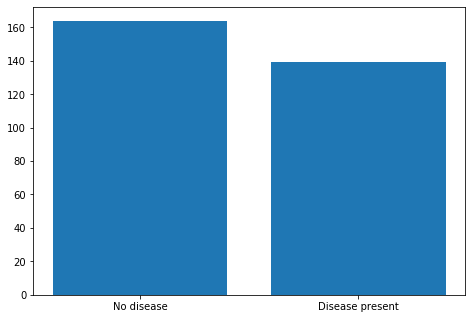

In [374]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

values = ["No disease", "Disease present"]
counts = data.hds.value_counts()

ax.bar(values, counts)
plt.show()

We can observe that the number of patients with and without heart disease is more or less balanced across the dataset. What would probably be interesting is how the presence of the heart disease is distributed among certain ages. We can see it on the plot below.

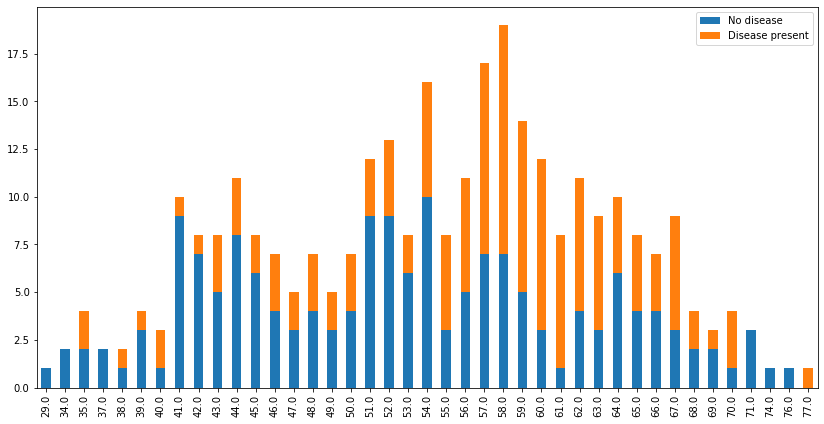

In [375]:
no_disease_age = data.loc[data["hds"] == 0, "age"].value_counts()
disease_age = data.loc[data["hds"] == 1, "age"].value_counts()

bar_data = pd.concat([no_disease_age, disease_age], axis=1)
bar_data.columns = ["No disease", "Disease present"]

bar_data.plot.bar(figsize=(14,7), stacked = True)

We can observe that up until the age of 55 the percentage of patients with no disease is higher than those with disease, but at the age of 55 till the age of 64 the tendency is opposite. After that it varies but the sample sizes of elder people are also getting smaller so it's not as objective as with the bigger samples.
***

## Models
In this chapter I will try and estimate 3 different types of models, that is: KNN, SVM and Logistic Regression. A comparison of those 3 methods could potentially give some interesting insight as well as enable us to compare their predictive power. In order to get good results we must first conduct binarization of nominal variables and possibly standarization of numerical ones.

### K-Nearest Neighbors
In order to use KNN efficiently we will first one-hot encode all the nominal variables from our dataset and standardize numerical ones. Then we will try to estimate KNN model for a dataset with standardized numerical variables and for the one without and see which yields better results.

In [376]:
nominal = data[["cp", "restecg", "slope", "ca", "thal"]].astype(object)
numerical = data[["age", "trestbps", "chol", "thalach", "oldpeak"]]

dummy = pd.get_dummies(nominal, drop_first=True)
print(dummy.shape)

numerical_std = numerical.apply(lambda x: (x-x.mean())/x.std())

data_bin = pd.concat([numerical, dummy, data[["sex", "exang", "fbs", "hds"]]], axis=1)
data_bin_norm = pd.concat([numerical_std, dummy, data[["sex", "exang", "fbs", "hds"]]], axis=1)
display(data_bin_norm.head())
display(data_bin.head())

(303, 12)


,age,trestbps,chol,thalach,oldpeak,cp_2.0,cp_3.0,cp_4.0,restecg_1.0,restecg_2.0,...,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0,sex,exang,fbs,hds
0,0.947160,0.756274,-0.264463,0.017169,1.085542,0,0,0,0,1,...,1,0,0,0,1,0,1.0,0.0,1.0,0
1,1.389703,1.608559,0.759159,-1.818896,0.396526,0,0,1,0,1,...,0,0,0,1,0,0,1.0,1.0,0.0,1
2,1.389703,-0.664201,-0.341717,-0.900864,1.343924,0,0,1,0,1,...,0,0,1,0,0,1,1.0,1.0,0.0,1
3,-1.929372,-0.096011,0.063869,1.634655,2.119067,0,1,0,0,0,...,1,0,0,0,0,0,1.0,0.0,0.0,0
4,-1.486829,-0.096011,-0.824558,0.978917,0.310399,1,0,0,0,1,...,0,0,0,0,0,0,0.0,0.0,0.0,0


,age,trestbps,chol,thalach,oldpeak,cp_2.0,cp_3.0,cp_4.0,restecg_1.0,restecg_2.0,...,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0,sex,exang,fbs,hds
0,63.0,145.0,233.0,150.0,2.3,0,0,0,0,1,...,1,0,0,0,1,0,1.0,0.0,1.0,0
1,67.0,160.0,286.0,108.0,1.5,0,0,1,0,1,...,0,0,0,1,0,0,1.0,1.0,0.0,1
2,67.0,120.0,229.0,129.0,2.6,0,0,1,0,1,...,0,0,1,0,0,1,1.0,1.0,0.0,1
3,37.0,130.0,250.0,187.0,3.5,0,1,0,0,0,...,1,0,0,0,0,0,1.0,0.0,0.0,0
4,41.0,130.0,204.0,172.0,1.4,1,0,0,0,1,...,0,0,0,0,0,0,0.0,0.0,0.0,0


Having the standarization and one-hot encoding sorted out we can take a look at the KNN model with all the variables and find out what is the optimal number of neighbors. We take into consideration numbers from 1 to 17 since we have 303 rows  and 17 is closest square root of that number. We also split the data into 70% train set and 30% test set. We then perform grid search across the range of values of neighbors. What it does is it performs, in our case, a 5-fold cross validation on the training set, finds the hyperparameter value for which the mean test accuracy of those cross validations is the highest. We can then use the model with that hyperparameter to predict on the test data, which wasn't used in the cross validation process.

We will also create a dataframe to store the metrics of our models in one place so that they are easily comparable. For that I chose two metrics, ROC area under curve score and accuracy, which should be a good metric in our case, since we don't have the case of having drastically imbalanced target variable.

In [377]:
results = pd.DataFrame(columns = ["Model", "ROC AUC score", "Accuracy"])

First we will try and predict using only binarized data, with numerical values intact. Then we will compare the results with binarized and standardized data.

In [378]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

y_norm = data_bin['hds'].values
X_norm = data_bin.drop('hds', axis = 1).values

neighbors = np.arange(1, 18)
param_grid = {'n_neighbors': neighbors}

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size = 0.3, random_state = 2020)

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 5, iid = True)
knn_cv.fit(X_train, y_train)
y_pred = knn_cv.predict(X_test)

print("Tuned KNN number of neighbors: {} \n".format(knn_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(knn_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(knn_cv.score(X_train, y_train)))

Tuned KNN number of neighbors: {'n_neighbors': 5} 

[[36 16]
 [17 22]]
              precision    recall  f1-score   support

           0       0.68      0.69      0.69        52
           1       0.58      0.56      0.57        39

    accuracy                           0.64        91
   macro avg       0.63      0.63      0.63        91
weighted avg       0.64      0.64      0.64        91

ROC AUC score: 0.6282051282051282
Test accuracy: 0.6373626373626373
Train accuracy: 0.7452830188679245


As we can clearly see the results are far from satisfying with barely 63% accuracy. Also the train accuracy is significantly higher tha test accuracy which may suggest a model overfitting. Let's try estimating again using standardized data.

In [379]:
y_norm = data_bin_norm['hds'].values
X_norm = data_bin_norm.drop('hds', axis = 1).values

neighbors = np.arange(1, 18)
param_grid = {'n_neighbors': neighbors}

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size = 0.3, random_state = 2020)

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 5, iid = True)
knn_cv.fit(X_train, y_train)
y_pred = knn_cv.predict(X_test)

print("Tuned KNN number of neighbors: {} \n".format(knn_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(knn_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(knn_cv.score(X_train, y_train)))

Tuned KNN number of neighbors: {'n_neighbors': 6} 

[[49  3]
 [12 27]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.87        52
           1       0.90      0.69      0.78        39

    accuracy                           0.84        91
   macro avg       0.85      0.82      0.82        91
weighted avg       0.84      0.84      0.83        91

ROC AUC score: 0.8173076923076923
Test accuracy: 0.8351648351648352
Train accuracy: 0.8018867924528302


In [380]:
results = results.append(pd.DataFrame({"Model": "KNN-6", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": knn_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

We can observe a significant improvement in predictiong power of the KNN algorithm and so we will stick with the second dataset for the rest of the project. As far as the above model is concerned the optimal number of parameters which yields the highest accuracy is for 6 neighbors. We can also see a confusion matrix which tells us how our model classified observations from the test set. We have 49 TPs, 3 FPs, 12 FNs and 27 TNs. That means our model predicted correctly 76 (TP + TN) out of 91 patients. From 15 wrongly predicted, 3 are those which didn't have disease but were predicted to have and 12 are those which have disease but were predicted as if they had not. This seems to be the biggest weakness of this particular model. It is shown directly by the recall value for 1 (0.69), which is significantly smaller than the rest of the metrics. The ROC area under curve on test data also is equal to 0.81, which isn't a bad result but can probably be improved. Last output shows us both the test and train set accuracies, which are fairly similar, so there seems to be neither overfitting nor underfitting problem.

### Support Vector Machines
Second model we will be performing is a Support Vector Machine. Following the pattern of KNN it benefits from having the supplied data binarized and standardized. However, SVMs can be linear and non-linear so we will check which one of them is better suited to our data. This time, the parameter passed to param_grid, along which GridSearchCV searches the best accuracy, is 'C' parameter standing for regularization. The boundaries for the range of values for parameters were narrowed down by previously testing different values, so that the computation wouldn't take ages.


In [381]:
from sklearn.svm import SVC

c = np.arange(1, 7, 0.15)
param_grid = {'C': c}

svc = SVC(cache_size = 500, kernel = 'linear',
          max_iter = -1, probability = True)
svc_cv = GridSearchCV(svc, param_grid, cv = 5, iid = True)
svc_cv.fit(X_train, y_train)
y_pred = svc_cv.predict(X_test)

print("Tuned C parameter: {} \n".format(svc_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(svc_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(svc_cv.score(X_train, y_train)))

Tuned C parameter: {'C': 4.899999999999998} 

[[49  3]
 [ 9 30]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        52
           1       0.91      0.77      0.83        39

    accuracy                           0.87        91
   macro avg       0.88      0.86      0.86        91
weighted avg       0.87      0.87      0.87        91

ROC AUC score: 0.8557692307692306
Test accuracy: 0.8681318681318682
Train accuracy: 0.8679245283018868


In [382]:
results = results.append(pd.DataFrame({"Model": "SVM linear", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": svc_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

What we can see from the output is that the linear version of svm produces better results than KNN algorithm altogether. The tuned paramter for which the accuracy is the highest is 4.9. Test and train accuracy are almost equal to each other and the ROC AUC score higher by around 0.04 in comparison to KNN. The model definitely improved in terms of predictin diseased patients, as it predictet 3 more TNs. The number of TPs stayed the same as previously.

Next on we will try both 'poly' and 'rbf' kernels to try and see if the results are any better than for linear kernel.

In [383]:
c = np.arange(1, 7, 0.15)
degree = np.arange(2, 6, 1)
param_grid = {'C': c, 'degree': degree}

svc = SVC(cache_size = 500, kernel = 'poly', max_iter = -1, 
          probability = True, gamma = 'auto')
svc_cv = GridSearchCV(svc, param_grid, cv = 5, iid = True)
svc_cv.fit(X_train, y_train)
y_pred = svc_cv.predict(X_test)

print("Tuned C and degree parameters: {} \n".format(svc_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(svc_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(svc_cv.score(X_train, y_train)))

Tuned C and degree parameters: {'C': 3.3999999999999986, 'degree': 2} 

[[50  2]
 [12 27]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        52
           1       0.93      0.69      0.79        39

    accuracy                           0.85        91
   macro avg       0.87      0.83      0.84        91
weighted avg       0.86      0.85      0.84        91

ROC AUC score: 0.826923076923077
Test accuracy: 0.8461538461538461
Train accuracy: 0.8584905660377359


In [384]:
results = results.append(pd.DataFrame({"Model": "SVM poly", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": svc_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

Using 'poly' kernel and searching through the same values of 'C' and degress from set [2,3,4,5], we can see that there is no combination of those two parameters that yields better overall results than linear kernel. However, this particular model is even better than previous two at predicting healthy people correctly. It could potentially be useful at dissmissing healthy patients so that the staff may focus on finding the sick within the rest. The optimal 'C' is 3.4 and number of degrees is 2. All in all, though, almost all the model's metrics decreased and it is rather a less useful model than linear SVM.

In [385]:
c = np.arange(0.05, 3, 0.05)
param_grid = {'C': c}

svc = SVC(cache_size = 500, kernel = 'rbf', max_iter = -1, 
          probability = True, gamma = 'auto')
svc_cv = GridSearchCV(svc, param_grid, cv = 5, iid = True)
svc_cv.fit(X_train, y_train)
y_pred = svc_cv.predict(X_test)

print("Tuned C parameter: {} \n".format(svc_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(svc_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(svc_cv.score(X_train, y_train)))

Tuned C parameter: {'C': 0.3} 

[[46  6]
 [ 8 31]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        52
           1       0.84      0.79      0.82        39

    accuracy                           0.85        91
   macro avg       0.84      0.84      0.84        91
weighted avg       0.85      0.85      0.85        91

ROC AUC score: 0.8397435897435896
Test accuracy: 0.8461538461538461
Train accuracy: 0.8254716981132075


In [386]:
results = results.append(pd.DataFrame({"Model": "SVM rbf", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": svc_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

For a 'rbf' kernel we got rid of degrees parameter since according to sklearn documentation degree parameter is ignored by all kernels apart from 'poly'. Thus we performed a grid search cross-validation only with respect to 'C' parameter. The optimal value was set to 0.3, for which the SVM's ROC AUC score and accuracy were worse than that of linear SVM's but better than KNNs and poly SVMs. Current model got worse at predicting healthy people, since now it predicts 6 of them wrongly. However it got better at predicting sick people, since now it predicts 31 out of 39 correctly which I think can be seen as improvement. Treating a healthy patient has less severe consequences than not treating a sick one.

### Logistic Regression
Last classification model that is going to be used in this project is logistic regression. As with previous models, the data is binarized and standardized. In our first step we would like to determine which regularization (Lasso or Ridge) would provide better results. To check this we assign both the parameter 'C' and two types of penalties to the parameter grid, 'l1' being Lasso regression and 'l2' being Ridge regression.

In [387]:
from sklearn.linear_model import LogisticRegression

c_log = np.logspace(-5, 5, 50)
param_grid = {'C': c_log, 'penalty': ['l1','l2']}

lr = LogisticRegression(solver = 'saga', max_iter = 100000)
lr_cv = GridSearchCV(lr, param_grid, cv = 5, iid = True)
lr_cv.fit(X_train, y_train)
y_pred = lr_cv.predict(X_test)

print("Tuned C and penalty parameters: {} \n".format(lr_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(lr_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(lr_cv.score(X_train, y_train)))

Tuned C and penalty parameters: {'C': 1.2648552168552958, 'penalty': 'l1'} 

[[48  4]
 [ 6 33]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        52
           1       0.89      0.85      0.87        39

    accuracy                           0.89        91
   macro avg       0.89      0.88      0.89        91
weighted avg       0.89      0.89      0.89        91

ROC AUC score: 0.8846153846153848
Test accuracy: 0.8901098901098901
Train accuracy: 0.8726415094339622


In [388]:
results = results.append(pd.DataFrame({"Model": "Logreg Lasso", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": lr_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

We can observe that the best results are obtained for 'C' equal to 1.26 and when l1 (Lasso) regularization is applied. Since Lasso is a form of variable selection and Ridge is not, it may suggest that we may have some variables whose removal would improve the model. The results are slightly worse at predicting healthy patients than poly SVM (two fewer TP predictions), but also slightly better at predicting sick patients (two TN predicted than for rbf SVM). The model follows previous tendency of smaller recall for 1's. Arguably it is the best model up to this moment, with both highest accuracy, ROC AUC score and detection rate for sick patients.

Logistic regression provides the possibilty of mixing L1 and L2 standarizations in a form of ElasticNet, which is a weighted combination of previous two - 'l1_ratio' being the weight of L1 regularization and 1-'l1_ratio' the weight of L2 regularization. We will try and see if it provides anything more to the results. The range of 'l1-ratio' was also previously tested and narrowed down to reduce the computation time.

In [389]:
c_log = np.logspace(-5, 5, 50)
l1_ratio = np.arange(0, 0.2, 0.05)
param_grid = {'C': c_log, 'l1_ratio': l1_ratio}

lr = LogisticRegression(solver = 'saga', penalty = 'elasticnet', max_iter = 10000000)
lr_cv = GridSearchCV(lr, param_grid, cv = 5, iid = True)
lr_cv.fit(X_train, y_train)
y_pred = lr_cv.predict(X_test)

print("Tuned C and l1_ratio parameters: {} \n".format(lr_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(lr_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(lr_cv.score(X_train, y_train)))

Tuned C and l1_ratio parameters: {'C': 2.0235896477251556, 'l1_ratio': 0.0} 

[[49  3]
 [ 7 32]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        52
           1       0.91      0.82      0.86        39

    accuracy                           0.89        91
   macro avg       0.89      0.88      0.89        91
weighted avg       0.89      0.89      0.89        91

ROC AUC score: 0.8814102564102564
Test accuracy: 0.8901098901098901
Train accuracy: 0.8726415094339622


In [390]:
results = results.append(pd.DataFrame({"Model": "Logreg ElasticNet", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": lr_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

After trying many different parameter ranges for l1_ratio the one above gave the best results in terms of ROC AUC score and accuracy. The output suggests that the L1 regularization should not be used at all to get the best results. The ElasticNet turned, in fact, into a Ridge regression (with 'C' parameter equal to 2.02) which also predicted 10 patients in total wrongly, same as previous Lasso regression. However it is worse at predicting true negatives. So we can say that it is very close in terms of overall usefulness, but falls just a bit short due to aforementioned importance of true negative detection.

So far we have obtained predictions using a few different methods and below we have a summary of how each model fares.

In [391]:
print(results.to_string(index=False))

             Model  ROC AUC score  Accuracy
             KNN-6       0.817308  0.835165
        SVM linear       0.855769  0.868132
          SVM poly       0.826923  0.846154
           SVM rbf       0.839744  0.846154
      Logreg Lasso       0.884615  0.890110
 Logreg ElasticNet       0.881410  0.890110


We can see that in terms of both ROC AUC score and accuracy are generally very much alike, with KNN and poly SVM models falling a bit short. All in all though, here is current list of models with highest score and accuracy:
1. Logreg Lasso
2. Logreg ElasticNet
3. SVM linear
4. SVM rbf
6. SVM poly
7. KNN-6

### Feature selection
All the previous models were calculated with all variables taken into consideration. Now we will take a look at feature selection to try and determine whether we can obtain better results if we omit certain variables. First off, let's take a look at the mutual information statistic.

In [392]:
nominal = ["cp", "restecg", "slope", "ca", "thal", "sex", "exang", "fbs"]
numerical = ["age", "trestbps", "chol", "thalach", "oldpeak"]

from sklearn import feature_selection

mutual_info_nominal = []
for var in nominal:
    mi = feature_selection.mutual_info_classif(data[var].values.reshape(-1,1), data["hds"].values, random_state = 2020)
    mutual_info_nominal.append([var, mi])

mutual_info_numerical = []
for var in numerical:
    mi = feature_selection.mutual_info_classif(data[var].values.reshape(-1,1), data["hds"].values, random_state = 2020)
    mutual_info_numerical.append([var, mi])

print("Nominal variables:")
display(mutual_info_nominal)
print("Numerical variables:")
display(mutual_info_numerical)

Nominal variables:


[['cp', array([0.12506337])],
 ['restecg', array([0.01978269])],
 ['slope', array([0.07265731])],
 ['ca', array([0.13758927])],
 ['thal', array([0.10760075])],
 ['sex', array([0.01412752])],
 ['exang', array([0.09035399])],
 ['fbs', array([0])]]

Numerical variables:


[['age', array([0.01754789])],
 ['trestbps', array([0])],
 ['chol', array([0.07485494])],
 ['thalach', array([0.08261985])],
 ['oldpeak', array([0.11335987])]]

From what we can see, variables 'fbs' and 'trestbps' are the ones with lowest values. Next in order are 'restecg', 'age' and 'sex' with values below 0.02. We can now try and calculate logistic regressions without these 'insignificant' variables to see whether it improves the model. We must alter our dataset accordingly first. We remove 'fbs' and 'trestbps' from our data.

In [393]:
nominal_fs = data[["cp", "slope", "ca", "thal", "restecg"]].astype(object)
numerical_fs = data[["chol", "thalach", "oldpeak", "age"]]

dummy_fs = pd.get_dummies(nominal_fs, drop_first=True)
numerical_std_fs = numerical_fs.apply(lambda x: (x-x.mean())/x.std())

data_bin_norm_fs = pd.concat([numerical_std_fs, dummy_fs, data[["exang", "hds", "sex"]]], axis=1)

display(data_bin_norm_fs.head())

,chol,thalach,oldpeak,age,cp_2.0,cp_3.0,cp_4.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0,restecg_1.0,restecg_2.0,exang,hds,sex
0,-0.264463,0.017169,1.085542,0.947160,0,0,0,0,1,0,0,0,1,0,0,1,0.0,0,1.0
1,0.759159,-1.818896,0.396526,1.389703,0,0,1,1,0,0,0,1,0,0,0,1,1.0,1,1.0
2,-0.341717,-0.900864,1.343924,1.389703,0,0,1,1,0,0,1,0,0,1,0,1,1.0,1,1.0
3,0.063869,1.634655,2.119067,-1.929372,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0,1.0
4,-0.824558,0.978917,0.310399,-1.486829,1,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0


### FS K-Nearest Neighbors
Now we can perform the same algorithms as before for our feature selected dataset and see whether there are any improvements to the predictions. All the models from before will be used on the feature selected data, as they would most likely achieve different scores and it could be useful knowing which improved and which regressed in terms of performance and prediction power.

In [394]:
y_norm_fs = data_bin_norm_fs['hds'].values
X_norm_fs = data_bin_norm_fs.drop('hds', axis = 1).values

X_train, X_test, y_train, y_test = train_test_split(X_norm_fs, y_norm_fs, test_size = 0.3, random_state = 2020)

neighbors = np.arange(1, 18)
param_grid = {'n_neighbors': neighbors}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 5, iid = True)
knn_cv.fit(X_train, y_train)
y_pred = knn_cv.predict(X_test)

print("Tuned KNN number of neighbors: {} \n".format(knn_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(knn_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(knn_cv.score(X_train, y_train)))

Tuned KNN number of neighbors: {'n_neighbors': 3} 

[[47  5]
 [ 8 31]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        52
           1       0.86      0.79      0.83        39

    accuracy                           0.86        91
   macro avg       0.86      0.85      0.85        91
weighted avg       0.86      0.86      0.86        91

ROC AUC score: 0.8493589743589743
Test accuracy: 0.8571428571428571
Train accuracy: 0.8537735849056604


In [395]:
results = results.append(pd.DataFrame({"Model": "FS KNN-3", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": knn_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

Clearly there is an overall improvement to the previous KNN model, with 4 more good predictions of sick patients and only two worse for healthy patients. Feature selection successfully detected insignificant variables and their omission turned out to improve the model. In terms of metrics it is now better than both poly and rbf SVMs and just slightly worse than linear SVM. 

### FS SVM
From the SVM 'tree' linear kernel seemed to perform the best, thus we perform it and hope to outperform its predecessor.

In [396]:
c = np.arange(1, 7, 0.15)
param_grid = {'C': c}

svc = SVC(cache_size = 500, kernel = 'linear',
          max_iter = -1, probability = True)
svc_cv = GridSearchCV(svc, param_grid, cv = 5, iid = True)
svc_cv.fit(X_train, y_train)
y_pred = svc_cv.predict(X_test)

print("Tuned C parameter: {} \n".format(svc_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(svc_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(svc_cv.score(X_train, y_train)))

Tuned C parameter: {'C': 4.4499999999999975} 

[[47  5]
 [ 9 30]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        52
           1       0.86      0.77      0.81        39

    accuracy                           0.85        91
   macro avg       0.85      0.84      0.84        91
weighted avg       0.85      0.85      0.84        91

ROC AUC score: 0.8365384615384616
Test accuracy: 0.8461538461538461
Train accuracy: 0.8584905660377359


In [397]:
results = results.append(pd.DataFrame({"Model": "FS SVM linear", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": svc_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

In the case of linear SVM, the feature selection method yielded worse results than before. Then number of false negatives increase as well as the number of false positives. In that case, I would like to see whether the tendency is spread across other types of SVM kernels. Thus we will perform also the poly and rbf versions of SVM. The poly version is next on the list.

In [398]:
c = np.arange(1, 7, 0.15)
degree = np.arange(2, 6, 1)
param_grid = {'C': c, 'degree': degree}

svc = SVC(cache_size = 500, kernel = 'poly',
          max_iter = -1, probability = True, gamma = 'auto')
svc_cv = GridSearchCV(svc, param_grid, cv = 5, iid = True)
svc_cv.fit(X_train, y_train)
y_pred = svc_cv.predict(X_test)

print("Tuned C parameter: {} \n".format(svc_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(svc_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(svc_cv.score(X_train, y_train)))

Tuned C parameter: {'C': 2.499999999999999, 'degree': 2} 

[[50  2]
 [12 27]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        52
           1       0.93      0.69      0.79        39

    accuracy                           0.85        91
   macro avg       0.87      0.83      0.84        91
weighted avg       0.86      0.85      0.84        91

ROC AUC score: 0.826923076923077
Test accuracy: 0.8461538461538461
Train accuracy: 0.8537735849056604


In [399]:
results = results.append(pd.DataFrame({"Model": "FS SVM poly", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": svc_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

In the case of poly kernel the results didn't change at all, which is quite interesting. Last SVM method is the one using rbf kernel.

In [400]:
c = np.arange(1, 4, 0.05)
param_grid = {'C': c}

svc = SVC(cache_size = 500, kernel = 'rbf',
          max_iter = -1, probability = True, gamma = 'auto')
svc_cv = GridSearchCV(svc, param_grid, cv = 5, iid = True)
svc_cv.fit(X_train, y_train)
y_pred = svc_cv.predict(X_test)

print("Tuned C parameter: {} \n".format(svc_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(svc_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(svc_cv.score(X_train, y_train)))

Tuned C parameter: {'C': 3.0500000000000016} 

[[49  3]
 [ 7 32]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        52
           1       0.91      0.82      0.86        39

    accuracy                           0.89        91
   macro avg       0.89      0.88      0.89        91
weighted avg       0.89      0.89      0.89        91

ROC AUC score: 0.8814102564102564
Test accuracy: 0.8901098901098901
Train accuracy: 0.8820754716981132


In [401]:
results = results.append(pd.DataFrame({"Model": "FS SVM rbf", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": svc_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

Here the results improved again, so we had all possible outcomes with the SVMs. Linear got worse, poly stayed the same and rbf got better. It achieved the ElasticNet's level of proficiency, scoring the exact same predictions as mentioned regression.

### FS Logistic Regression
Last on the list is logistic regression. We will do the Lasso or Ridge parameter grid search again and then try with ElasticNet and see what are the outcomes.

In [402]:
c_log = np.logspace(-5, 5, 50)
param_grid = {'C': c_log, 'penalty': ['l1','l2']}

lr = LogisticRegression(solver = 'saga', max_iter = 100000)
lr_cv = GridSearchCV(lr, param_grid, cv = 5, iid = True)
lr_cv.fit(X_train, y_train)
y_pred = lr_cv.predict(X_test)

print("Tuned C and penalty parameters: {} \n".format(lr_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(lr_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(lr_cv.score(X_train, y_train)))

Tuned C and penalty parameters: {'C': 33.9322177189533, 'penalty': 'l1'} 

[[47  5]
 [ 7 32]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        52
           1       0.86      0.82      0.84        39

    accuracy                           0.87        91
   macro avg       0.87      0.86      0.86        91
weighted avg       0.87      0.87      0.87        91

ROC AUC score: 0.8621794871794871
Test accuracy: 0.8681318681318682
Train accuracy: 0.8632075471698113


In [403]:
results = results.append(pd.DataFrame({"Model": "FS Logreg Lasso", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": lr_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

Here again the results are slightly worse than for its previous counterpart, achieving one less correct prediction for both TPs and TNs.

In [405]:
c_log = np.logspace(-5, 5, 50)
l1_ratio = np.arange(0, 1.01, 0.1)
param_grid = {'C': c_log, 'l1_ratio': l1_ratio}

lr = LogisticRegression(solver = 'saga', penalty = 'elasticnet', max_iter = 10000000)
lr_cv = GridSearchCV(lr, param_grid, cv = 5, iid = True)
lr_cv.fit(X_train, y_train)
y_pred = lr_cv.predict(X_test)

print("Tuned C and l1_ratio parameters: {} \n".format(lr_cv.best_params_))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC score: {}" .format(roc_auc_score(y_test, y_pred)))
print("Test accuracy: {}" .format(lr_cv.score(X_test, y_test)))
print("Train accuracy: {}" .format(lr_cv.score(X_train, y_train)))

Tuned C and l1_ratio parameters: {'C': 33.9322177189533, 'l1_ratio': 0.0} 

[[47  5]
 [ 7 32]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        52
           1       0.86      0.82      0.84        39

    accuracy                           0.87        91
   macro avg       0.87      0.86      0.86        91
weighted avg       0.87      0.87      0.87        91

ROC AUC score: 0.8621794871794871
Test accuracy: 0.8681318681318682
Train accuracy: 0.8632075471698113


In [406]:
results = results.append(pd.DataFrame({"Model": "FS Logreg ElasticNet", 
                             "ROC AUC score": roc_auc_score(y_test, y_pred),
                             "Accuracy": lr_cv.score(X_test, y_test)},
                             index=[0]),
                         ignore_index=True)

ElasticNet also yielded slightly worse results, again choosing to not take Lasso into account and sticking with Ridge. The 'C' parameter however is bigger than previously, but the prediction power is smaller. 
***

# Summary
Let's take a look at the results we obtained from each model and analyze some of their features.

In [407]:
results_sort = results.sort_values(by=['ROC AUC score'], ascending = False)
print(results_sort.to_string(index=False))

                Model  ROC AUC score  Accuracy
         Logreg Lasso       0.884615  0.890110
    Logreg ElasticNet       0.881410  0.890110
           FS SVM rbf       0.881410  0.890110
      FS Logreg Lasso       0.862179  0.868132
 FS Logreg ElasticNet       0.862179  0.868132
           SVM linear       0.855769  0.868132
             FS KNN-3       0.849359  0.857143
              SVM rbf       0.839744  0.846154
        FS SVM linear       0.836538  0.846154
             SVM poly       0.826923  0.846154
          FS SVM poly       0.826923  0.846154
                KNN-6       0.817308  0.835165


From this results table we can see that the Logistic Regression with Lasso penalty performed the best in terms of both  ROC AUC score and test set accuracy (on par with ElasticNet). If we get back to the classification report of the aforementioned Logistic regression model we will see that it achieved high recall of 0.92 for healthy people and lower for ill people (0.85). This means our model is better at detecting people without disease. 

As far as SVM models are concerned, both linear and rbf SVMs were noticeably worse at detecting TNs and slightly better at detecting TPs. So all in all they were less useful than Logreg model. SVM poly however achieved even higher recall value for 0's than aforementioned model and detected 96% of people without disease correctly. The drawback to this was much worse detection of disease presence. But this model could be used specifically just to detect healthy, due to it's high precision in that department.

Initial KNN model with 6 neighbours performed the worst of all tested models, both in terms of accuracy and ROC AUC score. Its power of correctly detection healthy people was on par with the best models but it stood out in terms of detecting sick patients. 12 out of 39 sick were wrongly classified as healthy which is an abysmal number.

Feature selection found out that some of the variables were not contributing much to the explanation of our target variable, thus in the next step I decided to leave them out and see if it impoves any of the models. In case of KNN it improved the model significantly. It was now (with 3 neighbours) able to 'compete' with previous models. All in all, though, the predictions were quite mediocre and earned a place in the middle of the table. The case with SVMs was quite interesting as for linear kernel the performance dropped, for poly didn't change at all and improved for rbf, achieving ex aequo second best result with ElasticNet. In terms of regressions, the feature selection method decreased the performance of both methods. Using feature selected data, both regressions scored the same results and predictions, which was a relatively bigger drop in performance for Lasso regression. Summing up, feature selection was a mixed bag, improving some, worsening some predictions, but reduced the number of variables needed, so in case we lacked the information provided by the omitted variables, this somehow might prove useful.